In [1]:
import pandas as pd
import numpy as np
import random
import re
import string
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import nlpaug.augmenter.word as naw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/syarif/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/syarif/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/syarif/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
app_reviews_df = pd.read_csv('scraped_data.csv')

jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

In [3]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,df8bf664-3082-4475-a490-b30eedb67e2c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The matchmaking needs a lot of help. I am only...,1,404,5.2.0.8065,2024-09-08 09:23:19,NaN,NaN,5.2.0.8065
1,d952df82-579c-456e-a9c6-f4d3a1cfd397,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Great, but now updates are giving me a headach...",3,20,6.0.0.8429,2025-01-17 11:55:18,NaN,NaN,6.0.0.8429
2,e933f7a2-c7d0-4997-8a12-5a89b98b7dc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Gameplay is good and spot on as in PC but the ...,3,2,6.0.0.8429,2025-02-01 11:18:56,NaN,NaN,6.0.0.8429
3,fa9dafa4-5375-4b99-801c-9e8fb3822f14,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"This game is incredible, it will ruin your lif...",5,256,6.0.0.8429,2025-01-12 14:17:14,NaN,NaN,6.0.0.8429
4,05bc4b3f-750e-4d47-95c3-13dd34142542,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I'm updating my review from my previous one. I...,4,64,6.0.0.8429,2025-01-16 20:11:07,NaN,NaN,6.0.0.8429


In [4]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  8952 non-null   object
 7   at                    12000 non-null  object
 8   replyContent          2197 non-null   object
 9   repliedAt             2197 non-null   object
 10  appVersion            8952 non-null   object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [5]:
clean_df = app_reviews_df.drop(columns=['replyContent','repliedAt'])
clean_df = clean_df.dropna()
clean_df = clean_df.drop_duplicates()

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8952 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              8952 non-null   object
 1   userName              8952 non-null   object
 2   userImage             8952 non-null   object
 3   content               8952 non-null   object
 4   score                 8952 non-null   int64 
 5   thumbsUpCount         8952 non-null   int64 
 6   reviewCreatedVersion  8952 non-null   object
 7   at                    8952 non-null   object
 8   appVersion            8952 non-null   object
dtypes: int64(2), object(7)
memory usage: 699.4+ KB


In [6]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  
    text = re.sub(r'RT[\s]', '', text)  
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.strip()
    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ') 
    return text
 
def casefoldingText(text): 
    text = text.lower()
    return text
 
def tokenizingText(text): 
    text = word_tokenize(text)
    return text
 
def filteringText(text): 
    listStopwords = set(stopwords.words('english'))
    listStopwords.update(listStopwords)
    listStopwords.update([
        'yes', 'yeah', 'no', 'its', 'the', 'so', 'me', 'in', 'not', 'ok', 
        'oh', 'is', 'hey', 'whoa', 'wow', 'i', 'you', 'we', 'they', 
        'this', 'that', 'it', 'are', 'and', 'or', 'from', 
        'for', 'to', 'with', 'by', 'on', 'which', 'in', 'for', 
        'like', 'when', 'a', 'an', 'within', 'such', 'how', 
        'towards', 'because', 'if', 'with', 'more', 'us', 'our', 
        'will', 'already', 'yet', 'can', 'be', 'what', 'maybe', 'must', 
        'not', 'same', 'already', 'on', 'all', 'after', 'again', 
        'less', 'only', 'means', 'until', 'before', 'when', 'shall', 
        'no', 'thus', 'however', 'whether', 'while', 'again', 'many', 
        'such', 'other', 'some', 'us', 'too', 'before', 'same', 
        'by', 'which', 'too', 'thus', 'but', 'very', 'maybe', 
        'also', 'is', 'most', 'where', 'when', 'there', 'can', 
        'ever', 'at once', 'once', 'in', 'for', 'nor', 'afraid', 
        'just', 'kind of', 'everything', 'thing', 'must', 'is not', 'is not a'
    ])


    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def lemmatizingText(text):  
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in text]
    return lemmatized_words  

 
def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [7]:
slangwords = {
    "@": "at",
    "gonna": "going to",
    "wanna": "want to",
    "lemme": "let me",
    "gimme": "give me",
    "gotta": "got to",
    "ain't": "is not",
    "brb": "be right back",
    "afk": "away from keyboard",
    "btw": "by the way",
    "idk": "I don't know",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "tbh": "to be honest",
    "omg": "oh my god",
    "smh": "shaking my head",
    "fyi": "for your information",
    "np": "no problem",
    "ty": "thank you",
    "thx": "thanks",
    "ttyl": "talk to you later",
    "gtg": "got to go",
    "jk": "just kidding",
    "nvm": "never mind",
    "hmu": "hit me up",
    "dm": "direct message",
    "gg": "good game",
    "ggwp": "good game, well played",
    "gr8": "great",
    "cya": "see you",
    "sup": "what's up",
    "yolo": "you only live once",
    "fomo": "fear of missing out",
    "roast": "make fun of",
    "stan": "hardcore fan",
    "savage": "bold",
    "extra": "over the top",
    "woke": "socially aware",
    "lowkey": "somewhat",
    "highkey": "very",
    "no cap": "no lie",
    "bet": "okay",
    "yeet": "throw",
    "lit": "exciting",
    "fire": "amazing",
    "slay": "do well",
    "goat": "greatest of all time",
    "mood": "relatable feeling",
    "sus": "suspicious",
    "simp": "overly affectionate",
    "flex": "show off",
    "toxic": "negative",
    "ghost": "ignore",
    "vibe": "atmosphere",
    "clapback": "sharp response",
    "sksksk": "express excitement",
    "periodt": "end of discussion",
    "cap": "lie",
    "tea": "gossip",
    "boujee": "luxurious",
    "basic": "unoriginal",
    "shook": "surprised",
    "stan": "big fan",
    "salty": "bitter",
    "ship": "support a relationship",
    "bop": "good song",
    "hype": "excited",
    "snatched": "stylish",
    "deadass": "serious",
    "big yikes": "very embarrassing",
    "pressed": "upset",
    "drip": "fashionable",
    "ratio": "more replies than likes",
    "main character": "self-centered",
    "send it": "go for it",
    "cap": "lie",
    "pog": "awesome",
    "based": "unapologetically true",
    "mid": "average",
    "bussin": "delicious",
}


def fix_slangwords(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text


In [8]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

clean_df['text_lemmatized'] = clean_df['text_stopword'].apply(lemmatizingText)

clean_df['text_akhir'] = clean_df['text_lemmatized'].apply(toSentence)


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

sentiments = SentimentIntensityAnalyzer()

clean_df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in clean_df["content"]]
clean_df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in clean_df["content"]]
clean_df['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in clean_df["content"]]
clean_df.head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/syarif/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_lemmatized,text_akhir,Positive,Negative,Compound
0,df8bf664-3082-4475-a490-b30eedb67e2c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The matchmaking needs a lot of help. I am only...,1,404,5.2.0.8065,2024-09-08 09:23:19,5.2.0.8065,The matchmaking needs a lot of help I am only ...,the matchmaking needs a lot of help i am only ...,the matchmaking needs a lot of help i am only ...,"[the, matchmaking, needs, a, lot, of, help, i,...","[matchmaking, needs, lot, help, level, keep, g...","[matchmaking, need, lot, help, level, keep, ge...",matchmaking need lot help level keep get match...,0.042,0.116,-0.8438
1,d952df82-579c-456e-a9c6-f4d3a1cfd397,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Great, but now updates are giving me a headach...",3,20,6.0.0.8429,2025-01-17 11:55:18,6.0.0.8429,Great but now updates are giving me a headache...,great but now updates are giving me a headache...,great but now updates are giving me a headache...,"[great, but, now, updates, are, giving, me, a,...","[great, updates, giving, headache, every, upda...","[great, update, give, headache, every, update,...",great update give headache every update last y...,0.247,0.052,0.9571
2,e933f7a2-c7d0-4997-8a12-5a89b98b7dc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Gameplay is good and spot on as in PC but the ...,3,2,6.0.0.8429,2025-02-01 11:18:56,6.0.0.8429,Gameplay is good and spot on as in PC but the ...,gameplay is good and spot on as in pc but the ...,gameplay is good and spot on as in pc but the ...,"[gameplay, is, good, and, spot, on, as, in, pc...","[gameplay, good, spot, pc, controls, bit, wack...","[gameplay, good, spot, pc, control, bite, wack...",gameplay good spot pc control bite wacked grap...,0.029,0.159,-0.8702
3,fa9dafa4-5375-4b99-801c-9e8fb3822f14,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"This game is incredible, it will ruin your lif...",5,256,6.0.0.8429,2025-01-12 14:17:14,6.0.0.8429,This game is incredible it will ruin your life...,this game is incredible it will ruin your life...,this game is incredible it will ruin your life...,"[this, game, is, incredible, it, will, ruin, y...","[game, incredible, ruin, life, though, laughin...","[game, incredible, ruin, life, though, laugh, ...",game incredible ruin life though laugh loud iv...,0.270,0.087,0.9411
4,05bc4b3f-750e-4d47-95c3-13dd34142542,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I'm updating my review from my previous one. I...,4,64,6.0.0.8429,2025-01-16 20:11:07,6.0.0.8429,Im updating my review from my previous one I r...,im updating my review from my previous one i r...,im updating my review from my previous one i r...,"[im, updating, my, review, from, my, previous,...","[im, updating, review, previous, one, really, ...","[im, update, review, previous, one, really, ga...",im update review previous one really game stut...,0.192,0.084,0.8957


In [16]:
score = clean_df["Compound"].values
sentiment = []

for i in score:
    if i >= 0: 
        sentiment.append('positive')
    else:  
        sentiment.append('negative')

clean_df["polarity"] = sentiment

In [17]:
print(clean_df['polarity'].value_counts())

polarity
positive    5896
negative    3056
Name: count, dtype: int64


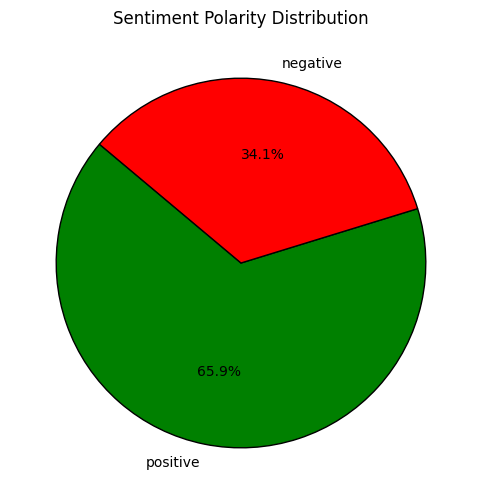

In [39]:
polarity_counts = clean_df['polarity'].value_counts()

colors = {'positive': 'green', 'negative': 'red'}

plt.figure(figsize=(6, 6))
plt.pie(
    polarity_counts.values, 
    labels=polarity_counts.index, 
    autopct='%1.1f%%', 
    colors=[colors[key] for key in polarity_counts.index],
    startangle=140, 
    wedgeprops={'edgecolor': 'black'}
)

plt.title("Sentiment Polarity Distribution")

plt.show()

In [143]:
synonym_aug = naw.SynonymAug(aug_p=0.2) 
shuffle_aug = naw.RandomWordAug(action="swap", aug_p=0.2)  
delete_aug = naw.RandomWordAug(action="delete", aug_p=0.2)  

def augment_text(text):
    aug_methods = [synonym_aug, shuffle_aug, delete_aug]
    aug = random.choice(aug_methods)  
    augmented_text = aug.augment(text)
    
    if isinstance(augmented_text, list):  
        return " ".join(augmented_text)  
    
    return augmented_text 


augmented_df = clean_df.copy()
augmented_df['text_akhir'] = augmented_df['text_akhir'].apply(augment_text)

final_df = pd.concat([clean_df, augmented_df]).reset_index(drop=True)

X = final_df['text_akhir']
y = final_df['polarity']

custom_stop_words = ['ad', 'adc', 'adcs', 'acc']

tfidf = TfidfVectorizer(max_features=20000, min_df=10, max_df=0.5, ngram_range=(1,2), stop_words=custom_stop_words)
X_tfidf = tfidf.fit_transform(X) 

features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  
y_encoded = np.array(y_encoded, dtype=np.float32).reshape(-1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

selector = SelectKBest(chi2, k=5000)  
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/syarif/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [144]:
features_df.describe()

,2d,2nd,aatrox,abandon,abandon game,abandon match,abilities,ability,ability button,abit,...,youtube,youve,youve play,yrs,yt,zed,zero,zero star,zoe,zoom
count,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,...,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000,17904.000000
mean,0.000171,0.000194,0.000203,0.000682,0.000295,0.000152,0.001383,0.001783,0.000125,0.000164,...,0.000348,0.000722,0.000163,0.000216,0.000111,0.000374,0.001039,0.000256,0.000128,0.000528
std,0.006654,0.006317,0.007177,0.011993,0.008153,0.006149,0.016091,0.017944,0.005340,0.005931,...,0.008430,0.011889,0.006112,0.006699,0.004716,0.009704,0.014313,0.007935,0.005452,0.013563
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.460937,0.243085,0.437332,0.475266,0.344712,0.419601,0.390241,0.422250,0.283130,0.260443,...,0.267445,0.316943,0.282642,0.284063,0.239428,0.497306,0.326109,0.385430,0.278706,0.630182


In [145]:
important_words = tfidf.get_feature_names_out()
print(important_words[:50])

['2d' '2nd' 'aatrox' 'abandon' 'abandon game' 'abandon match' 'abilities'
 'ability' 'ability button' 'abit' 'able' 'able bodied' 'able choose'
 'able connect' 'able enter' 'able get' 'able log' 'able login'
 'able play' 'able reconnect' 'able see' 'able use' 'about' 'absolute'
 'absolute garbage' 'absolute trash' 'absolutely' 'absolutely amaze'
 'absolutely love' 'absolutely terrible' 'absurd' 'absurdly' 'abuse'
 'abusive' 'abysmal' 'accept' 'accept button' 'accept match' 'acceptable'
 'access' 'access game' 'accessable' 'accessibility' 'accessible'
 'accidentally' 'accord' 'accordingly' 'account' 'account doesnt'
 'account even']


In [146]:
print(f"Number of features: {X_tfidf.shape[1]}")


Number of features: 10034


In [149]:
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.005), input_shape=(X_train_selected.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])



early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)


optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_selected, y_train, epochs=70, batch_size=32, validation_data=(X_test_selected, y_test), callbacks=[early_stopping,lr_scheduler])


loss, accuracy = model.evaluate(X_test_selected, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/70


/Users/syarif/tensorflow/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6683 - loss: 2.3116 - val_accuracy: 0.8023 - val_loss: 0.6158 - learning_rate: 5.0000e-04
Epoch 2/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8153 - loss: 0.6144 - val_accuracy: 0.8274 - val_loss: 0.5926 - learning_rate: 5.0000e-04
Epoch 3/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8410 - loss: 0.5789 - val_accuracy: 0.8199 - val_loss: 0.5910 - learning_rate: 5.0000e-04
Epoch 4/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8499 - loss: 0.5630 - val_accuracy: 0.8472 - val_loss: 0.5612 - learning_rate: 5.0000e-04
Epoch 5/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8614 - loss: 0.5441 - val_accuracy: 0.8559 - val_loss: 0.5481 - learning_rate: 5.0000e-04
Epoch 6/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8674 - loss: 0.5260 - val_accuracy: 0.8604 - val_loss: 0.5307 - learning_rate: 5.0000e-04
Epoch 7/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8710 - lo

In [151]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

joblib.dump(selector, 'selectkbest.pkl')

joblib.dump(label_encoder, 'label_encoder.pkl')

joblib.dump(model, 'model.pkl')


['model.pkl']